In [22]:
#-- Import Modules
import os
import glob
import rasterio
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage.graph import route_through_array

In [23]:
#-- directory setup
gdrive = os.path.expanduser('~/Google Drive File Stream/My Drive/')
indir = os.path.join(gdrive,'Colab Notebooks')
outdir = os.path.expanduser('~/GL_learning_data/slant_data')

In [24]:
#-- get list of files
# subdir = 'unet_weights_32init_4down_drop0.2_augmented.dir'
# subdir = 'unet_weights_32init_4down_drop0.2.dir'
subdir = 'atrous_32init_drop0.2.dir'
# fileList = glob.glob(os.path.join(indir,'Train_predictions.dir',subdir,'*_pred.png'))
fileList = glob.glob(os.path.join(indir,'Test_predictions.dir',subdir,'*_pred.png'))
fileList

['/Users/yaramohajerani/Google Drive File Stream/My Drive/Colab Notebooks/Test_predictions.dir/atrous_32init_drop0.2.dir/Track002891-013962-013787-002891_T043448_07_07_pred.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/Colab Notebooks/Test_predictions.dir/atrous_32init_drop0.2.dir/Track002833-013904-013729-002833_T050828_07_07_pred.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/Colab Notebooks/Test_predictions.dir/atrous_32init_drop0.2.dir/Track002891-013962-013787-002891_T043448_10_10_pred.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/Colab Notebooks/Test_predictions.dir/atrous_32init_drop0.2.dir/Track002833-013904-013729-002833_T050828_10_10_pred.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/Colab Notebooks/Test_predictions.dir/atrous_32init_drop0.2.dir/Track002833-013904-013729-002833_T050828_09_09_pred.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/Colab Notebooks/Test_predictions.dir/atrous_32i

In [25]:
#-- make corresponding output folder
# out_subdir = os.path.join(outdir,'Train_predictions.dir',subdir)
out_subdir = os.path.join(outdir,'Test_predictions.dir',subdir)
if (not os.path.isdir(out_subdir)):
    os.mkdir(out_subdir)

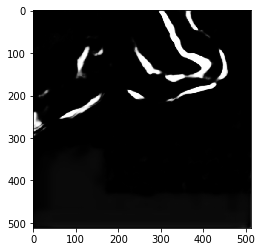

In [26]:
#-- Read an image to test
f = fileList[10]
im = imageio.imread(f).astype(float)/255.
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

In [27]:
print(im.max(),im.min())
print(np.count_nonzero(im > 0.5))
print(np.count_nonzero(im < 0.5))

1.0 0.0
10090
252054


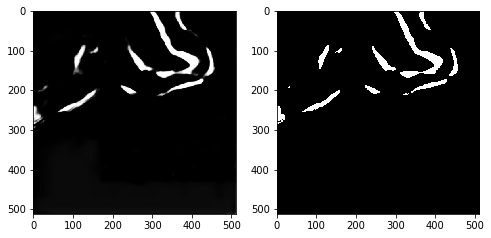

In [28]:
im2 = im.copy()
#-- threshold iamge
ii = np.where(im < 0.5)
jj = np.where(im >= 0.5)
im2[ii] = 0.
im2[jj] = 1.
fig,ax = plt.subplots(1, 2,figsize=(8,6))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im2, cmap=plt.cm.gray)
plt.show()

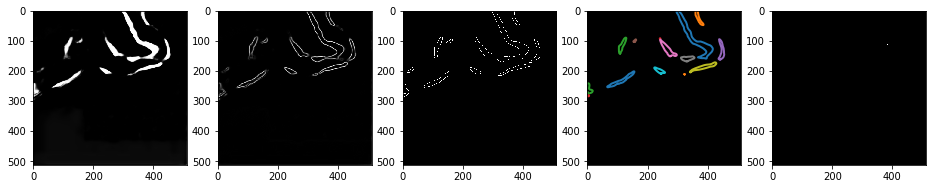

In [29]:
from skimage import filters
from skimage import feature
from skimage import measure
from skimage.morphology import skeletonize

edge_sobel = filters.sobel(im)
edge_canny = feature.canny(im,sigma=3)
contours = measure.find_contours(im, 0.8)
skeleton = skeletonize(im)

fig,ax = plt.subplots(1,5,figsize=(16,8))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[2].imshow(edge_canny, cmap=plt.cm.gray)
ax[3].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
for n, contour in enumerate(contours):
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[4].imshow(skeleton, cmap=plt.cm.gray)
plt.show()

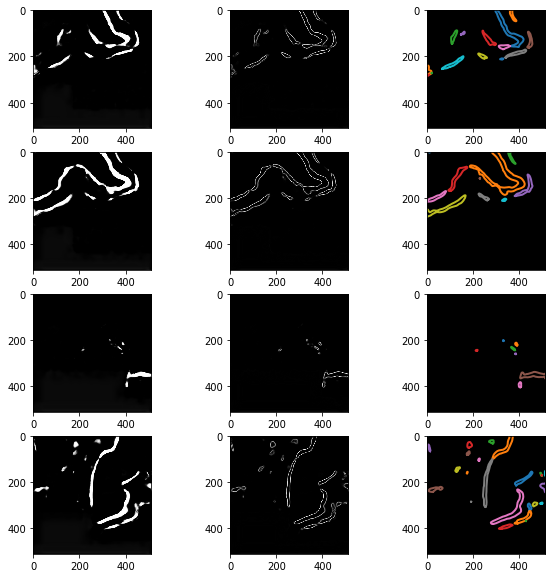

In [30]:
inds = [10,15,20,30]
fig,ax = plt.subplots(4,3,figsize=(10,10))
for j,i in enumerate(inds):
    f = fileList[i]
    im = imageio.imread(f).astype(float)/255.
    edge_sobel = filters.sobel(im)   
    contours = measure.find_contours(im, 0.6)
    ax[j,0].imshow(im, cmap=plt.cm.gray)
    ax[j,1].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[j,2].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        ax[j,2].plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

In [31]:
ii = np.where(im > 0.98)
print(ii[0][0],ii[1][0])
print(ii[0][-1],ii[1][-1])

0 366
401 323


In [32]:
#-- get route through array
ii = np.where(im > 0.98)
startPoint = (ii[0][-1],ii[1][-1])
endPoint = (ii[0][0],ii[1][0])

testIndices, testWeight = route_through_array(im, (startPoint[0], startPoint[1]),
                                              (endPoint[0], endPoint[1]), geometric=True,fully_connected=True)

In [33]:
testIndices = np.array(testIndices)
print(testIndices)
print(testIndices.shape)
print(im.size)

[[401 323]
 [402 323]
 [403 323]
 ...
 [  0 368]
 [  0 367]
 [  0 366]]
(15767, 2)
262144


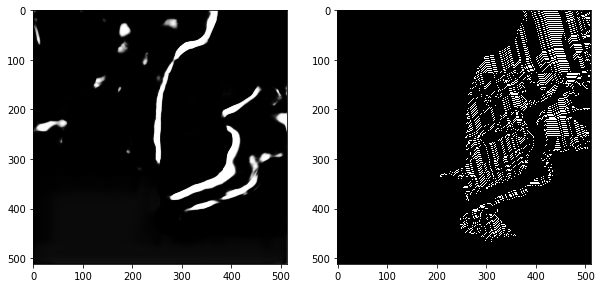

In [34]:
im_test = np.zeros(im.shape)
im_test[testIndices[:,0],testIndices[:,1]] = 1
# im_test[startPoint[0]-20:startPoint[0]+20, startPoint[1]-20:startPoint[1]+20] = 1
# im_test[endPoint[0], endPoint[1]] = 1
fig,ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im_test, cmap=plt.cm.gray)
plt.show()

## Run through all images and save contours

In [35]:
ddir = os.path.expanduser('~/Google Drive File Stream/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/')
train_dir = os.path.join(ddir,'Slant_Imagery','training_data')
test_dir = os.path.join(ddir,'Slant_Imagery','testing_data')

In [36]:
#-- Get list of images
fList = os.listdir(train_dir)
train_list = [f for f in fList if f.endswith('_coco.tif')]
fList = os.listdir(test_dir)
test_list = [f for f in fList if f.endswith('_coco.tif')]

In [37]:
raster = rasterio.open(os.path.join(train_dir,train_list[15]))
im = raster.read(1)
channels = raster.count
raster.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 3,
 'crs': None,
 'transform': Affine(0.0, 0.0, 0.0,
        0.0, 0.0, 0.0)}

In [38]:
#-- get list of file names
file_list_name = [os.path.basename(f) for f in fileList]
#-- Read images and save to file
# for i,f in enumerate(train_list):
for i,f in enumerate(test_list):
    fig,ax = plt.subplots(1,4,figsize=(16,5))
        
    train_img = np.ones((im.shape[0],im.shape[1],channels))
    train_lbl = np.ones((im.shape[0],im.shape[1]))
    #-- read image
    raster = rasterio.open(os.path.join(test_dir,f))
    for c in range(channels):
        train_img[:,:,c] = raster.read(c+1)
    #-- read label
    raster = rasterio.open(os.path.join(test_dir,f.replace('coco.tif','mask.tif')))
    train_lbl[:,:] = raster.read(1)

    #-- find corresponding prediction file
    file_ind = file_list_name.index(f.replace('_coco.tif','_pred.png'))
    im = imageio.imread(fileList[file_ind]).astype(float)/255. 
    contours = measure.find_contours(im, 0.3)
    ax[0].imshow(train_img)
    ax[1].imshow(train_lbl, cmap=plt.cm.gray)
    ax[2].imshow(im, cmap=plt.cm.gray)
    ax[3].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    for ix in range(4):
        ax[ix].set_axis_off()
    plt.savefig(os.path.join(out_subdir,f.replace('coco.tif','.png')),format='PNG')
    plt.close()